In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import ares
from math import ceil

In [2]:
#loading the EDGES data (the e subscipt is related to EDGES)
data_1 = pd.read_csv('data_1.csv')
freq_e = data_1.iloc[:,0] #frequency, MHz

#Changing the axis from frequency to redshift
v_0 = 1420 #MHz, frequency of 21cm line
z_e = (v_0/freq_e)-1 #conversion of frequency to redshift

In [3]:
def dict_to_list(d): #converts dictionary to two lists (key and value)
    #d must be a dictionary containing the value of parameters and their names
    key = list(d.keys())
    value = list(d.values())
    return value, key

def list_to_dict(value, key): #converts two lists (key and value) to a dictionary
    #value is a list of parameters' values
    #key is a list of parameters' names
    return dict(zip(key, value))

def call_ares (params, redshifts): 
    #params should be a dictionary
    #value, key = dict_to_list(params)
    
    #value_denormalized = np.array(value, dtype='float64')
    #value_denormalized[0] = 10** (value[0])
    #value_denormalized[1] = 10** (value[1])
    #value_denormalized[2] = 10** (value[2])
    #params_denormalized = list_to_dict(value_denormalized, key)
    
    #running ares
    #sim = ares.simulations.Global21cm(**params_denormalized, verbose=False, progress_bar=False)
    sim = ares.simulations.Global21cm(**params, verbose=False, progress_bar=False)
    sim.run()
    z = sim.history['z'][::-1]
    dTb = sim.history['dTb'][::-1]
    z = z[z<50]
    dTb = dTb[:len(z)]
    spline = CubicSpline(z, dTb)
    
    return spline(redshifts) 

def ares_deriv (m, z, d = 1E-2): 
    #I can further change this function to include the best dx - 4*int(1E5) is the best number I found so far
    #m is the list of params 
    #z is the redshift range
    #y is the brightness temp
    m = np.array(m)
    T = call_ares(list_to_dict(m, key), z)
    derivs = np.zeros([len(z), len(m)])
    dpars = d * m
    dpars = np.array(dpars, copy=True, dtype = 'float64')
    
    for i in range(len(m)):        
        pars_plus = np.array(m, copy=True, dtype = 'float64')
        pars_plus[i] = pars_plus[i] + dpars[i]
        
        pars_minus = np.array(m, copy=True, dtype = 'float64')
        pars_minus[i] = pars_minus[i] - dpars[i]
        
        A_plus = call_ares (list_to_dict(pars_plus, key), z)
        A_minus = call_ares (list_to_dict(pars_minus, key), z)
        A_m = (A_plus - A_minus)/(2*dpars[i])
        derivs[:, i] = A_m    
    return T, derivs

def update_lamda(lamda, success):
    if success:
        lamda = lamda/1.5
        if lamda<0.5:
            lamda=0
    else:
        if lamda==0:
            lamda=1
        else:
            lamda = lamda*1.5**2
            #lamda = lamda*2
    return lamda

def get_matrices(m, fun, x, y, Ninv):
    model, derivs = fun(m, x)
    r = y-model
    lhs = derivs.T@Ninv@derivs
    rhs = derivs.T@(Ninv@r)
    chisq = r.T@Ninv@r
    return chisq, lhs, rhs

def linv(mat, lamda):
    mat = mat + lamda*np.diag(np.diag(mat))
    return np.linalg.pinv(mat)

def LM(m, fun, x, y, Ninv, niter=10, chitol= 1): 
    lamda=0
    #m = check_limits_lm(m)
    chisq, lhs, rhs = get_matrices(m, fun, x, y, Ninv)
    
    for i in range(niter):
        lhs_inv = linv(lhs, lamda)
        dm = lhs_inv@rhs
        m_new = m+dm
        #print(dm)
        #m_new = check_limits_lm(m+dm)
        chisq_new, lhs_new, rhs_new = get_matrices(m_new, fun, x, y, Ninv)

        #try:
         #   chisq_new, lhs_new, rhs_new = get_matrices(m+dm, fun, x, y, Ninv)
        #except:
            
        if chisq_new<chisq:  
            if lamda==0:
                if (np.abs(chisq-chisq_new)<chitol):
                    print('Converged after ', i, ' iterations of LM')
                    return m_new
            chisq = chisq_new
            lhs = lhs_new
            rhs = rhs_new
            m = m_new
            lamda = update_lamda(lamda,True)
            
        else:
            lamda = update_lamda(lamda, False)
        #print('on iteration ', i, ' chisq is ', chisq, ' with step ', dm, ' and lamda ', lamda)
        print('\n', 'on iteration ', i, ' chisq is ', chisq, ' and lamda is ', lamda)
        #print('step ', dm)
        #print('new params ', m_new)
                
    return m

def draw_samples(covariance_matrix, nset):
    #normalizing the covariance matrix
    D = np.diag(np.diag(covariance_matrix)) #diagonal matrix of covariance matrix
    D_sqrt = np.sqrt(D)
    D_inv_sqrt = np.linalg.pinv(D_sqrt)
    covariance_matrix_normalized = D_inv_sqrt @ covariance_matrix @ D_inv_sqrt #normalized covariance matrix

    e,v = np.linalg.eigh(covariance_matrix_normalized)
    e[e<0]=0 #make sure we don't have any negative eigenvalues due to roundoff
    n = len(e)

    #make gaussian random variables
    g=np.random.randn(n, nset)

    #now scale them by the square root of the eigenvalues
    rte=np.sqrt(e)
    for i in range(nset):
        g[:,i]=g[:,i]*rte

    #and rotate back into the original space
    samples = (v@g).T
    samples_denormalized = samples @ D_sqrt
    return samples_denormalized

def chisquare (pars, data, Ninv): #returns the chi-square of two 21cm curves - err can be a number/array   
    pred = call_ares(list_to_dict(pars, key), z_e)
    r = data-pred
    chisq = r.T@Ninv@r
    return chisq

In [4]:
#dict_true = {'pop_rad_yield_0_': 1E4, 'pop_rad_yield_1_': 1E29, 'pop_rad_yield_2_': 1E5, 'clumping_factor': 1.7} 
dict_true = {'pop_rad_yield_0_': 1E4, 'pop_rad_yield_2_': 1E5, 'clumping_factor': 1.7, 'fX': 0.1} 
m_true, key = dict_to_list(dict_true)
m_true = np.array(m_true, copy=True, dtype = 'float64')
y_true = call_ares(list_to_dict(m_true, key), z_e)
#m_0 = m_true * (1 +  0.1* np.random.randn(len(m_true)))
#m_0 = [10**(3.9), 10**(28.0), 10**(5.2), 1.5]
m_0 = [10**(3.9), 10**(5.2), 1.5, 0.3]
err = 1E-3
Ninv = ((err)**(-2))*np.eye(len(z_e))

In [5]:
m_true

array([1.0e+04, 1.0e+05, 1.7e+00, 1.0e-01])

123879376900.95654


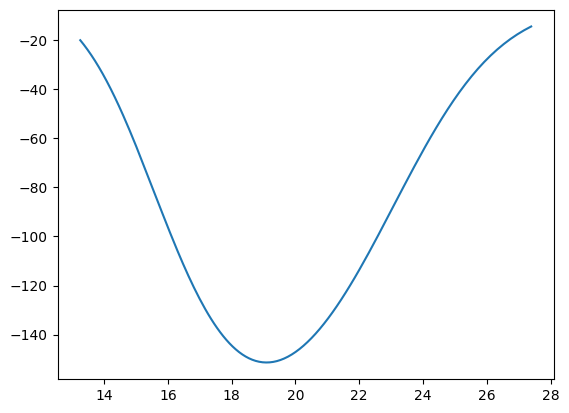

In [6]:
print(chisquare(m_0, y_true, Ninv))
plt.plot(z_e, y_true, label = 'True')

In [7]:
#m_fit = LM (m_0, ares_deriv, z_e, y_true, niter=20, Ninv = Ninv)
m_fit= m_true
chisq_f, lhs_f, rhs_f = get_matrices(m_0, ares_deriv, z_e, y_true, Ninv)
mycov = lhs_f
y_fit = call_ares(list_to_dict(m_fit, key), z_e)

In [8]:
#error bars
mycovinv= np.linalg.inv(mycov)
np.sqrt(np.diag(mycovinv))

array([8.01369974e-02, 5.49697058e+00, 2.45250466e-04, 8.02433762e-06])

In [9]:
mycovinv

array([[ 6.42193835e-03, -3.35083949e-01, -1.68150631e-05,
        -5.32518724e-07],
       [-3.35083949e-01,  3.02166856e+01,  1.28123050e-03,
         3.09760274e-05],
       [-1.68150631e-05,  1.28123050e-03,  6.01477911e-08,
         1.74641455e-09],
       [-5.32518724e-07,  3.09760274e-05,  1.74641455e-09,
         6.43899943e-11]])

In [10]:
m_fit

array([1.0e+04, 1.0e+05, 1.7e+00, 1.0e-01])